# 20211027 - 과제 (4) - 한상희

---

# 문제 1

- 데이터 전체 기간에서 테러의 숫자를 연도별로 집계하여 연도별 테러 숫자 시각화 하기
- 전세계 테러 발생수중 특정 연도 기점으로 갑자기 증가하는 부분 찾고 그 기점의 세계적 이슈가 무엇이 있었는지 추측하기

In [55]:
# 필요 모듈 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
import platform
from matplotlib import font_manager, rc
import json

In [34]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
get_ipython().run_line_magic("matplotlib", "inline")

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unknown system sorry.")

In [3]:
raw_data = pd.read_csv('./globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')
raw_data.head()

C:\Users\sanghui\miniconda3\envs\ds_study\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
# 공격 타입 체크1
raw_data['attacktype1_txt'][:10]

0                     Assassination
1       Hostage Taking (Kidnapping)
2                     Assassination
3                 Bombing/Explosion
4    Facility/Infrastructure Attack
5                     Armed Assault
6                     Assassination
7                 Bombing/Explosion
8    Facility/Infrastructure Attack
9    Facility/Infrastructure Attack
Name: attacktype1_txt, dtype: object

In [5]:
# 공격 타입 체크2
raw_data['attacktype2_txt'][:10]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
Name: attacktype2_txt, dtype: object

In [6]:
# 컬럼 이름 renaming
raw_data.rename(columns={
'iyear':'Year',
'imonth':'Month',
'iday':'Day',
'country_txt':'Country', # 발생국가
'region_txt':'Region', #발생국가 > 발생지역
'attacktype1_txt':'AttackType', # 공격 타입 (폴팔테러, 시설 습격 등등)
'target1':'Target',
'nkill':'Killed',
'nwound':'Wounded',
'summary':'Summary', # 해당사건 발생 일자 + 사건명
'gname':'Group', # 테러 주체
'targtype1_txt':'Target_type',
'weaptype1_txt':'Weapon_type',
'motive':'Motive'},inplace=True)

# 사용할 컬럼만 뽑아오기
raw_data=raw_data[
    ['Year','Month','Day','Country','Region','city','latitude','longitude','AttackType',
    'Killed','Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive']]
    
# 사상자 컬럼 추가
raw_data['casualities']=raw_data['Killed']+raw_data['Wounded']

In [7]:
raw_data.head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,casualities
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,Julio Guzman,NaN,MANO-D,Private Citizens & Property,Unknown,NaN,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,Hostage Taking (Kidnapping),0.0,0.0,"Nadine Chaval, daughter",NaN,23rd of September Communist League,Government (Diplomatic),Unknown,NaN,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Employee,NaN,Unknown,Journalists & Media,Unknown,NaN,1.0
3,1970,1,0,Greece,Western Europe,Athens,37.997490,23.762728,Bombing/Explosion,NaN,NaN,U.S. Embassy,NaN,Unknown,Government (Diplomatic),Explosives,NaN,NaN
4,1970,1,0,Japan,East Asia,Fukouka,33.580412,130.396361,Facility/Infrastructure Attack,NaN,NaN,U.S. Consulate,NaN,Unknown,Government (Diplomatic),Incendiary,NaN,NaN


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Year         181691 non-null  int64  
 1   Month        181691 non-null  int64  
 2   Day          181691 non-null  int64  
 3   Country      181691 non-null  object 
 4   Region       181691 non-null  object 
 5   city         181257 non-null  object 
 6   latitude     177135 non-null  float64
 7   longitude    177134 non-null  float64
 8   AttackType   181691 non-null  object 
 9   Killed       171378 non-null  float64
 10  Wounded      165380 non-null  float64
 11  Target       181055 non-null  object 
 12  Summary      115562 non-null  object 
 13  Group        181691 non-null  object 
 14  Target_type  181691 non-null  object 
 15  Weapon_type  181691 non-null  object 
 16  Motive       50561 non-null   object 
 17  casualities  164817 non-null  float64
dtypes: float64(5), int64(3),

In [9]:
# 임시 저장
raw_data.to_csv("./raw_data2.csv", sep=",", encoding="utf-8")

- 전체 기간에서 연도별로 테러수 집계해보기

In [10]:
# 연도별 발생 횟수 집계
raw_data["Year"].value_counts()[:10]

2014    16903
2015    14965
2016    13587
2013    12036
2017    10900
2012     8522
2011     5076
1992     5071
2010     4826
2008     4805
Name: Year, dtype: int64

In [11]:
# 데이터 프레임으로 변환
yearly_data = pd.DataFrame(data=raw_data["Year"].value_counts())
yearly_data.head()

,Year
2014,16903
2015,14965
2016,13587
2013,12036
2017,10900


In [12]:
yearly_data.reset_index(inplace=True)
yearly_data.tail()


,index,Year
42,1970,651
43,1974,581
44,1972,568
45,1973,473
46,1971,471


In [13]:
yearly_data.rename(columns={"index": "연도", "Year": "발생건수"}, inplace=True)
yearly_data.tail()

,연도,발생건수
42,1970,651
43,1974,581
44,1972,568
45,1973,473
46,1971,471


In [14]:
# 연도별로 정렬이 되어있지 않으므로 sort
yearly_data = yearly_data.sort_values(by="연도")
yearly_data.tail()

,연도,발생건수
3,2013,12036
0,2014,16903
1,2015,14965
2,2016,13587
4,2017,10900


In [15]:
# 인덱스 다시 잡아주기
yearly_data.reset_index(inplace=True)
yearly_data.head()

,index,연도,발생건수
0,42,1970,651
1,46,1971,471
2,44,1972,568
3,45,1973,473
4,43,1974,581


In [16]:
del yearly_data["index"]
yearly_data.head()

,연도,발생건수
0,1970,651
1,1971,471
2,1972,568
3,1973,473
4,1974,581


No handles with labels found to put in legend.


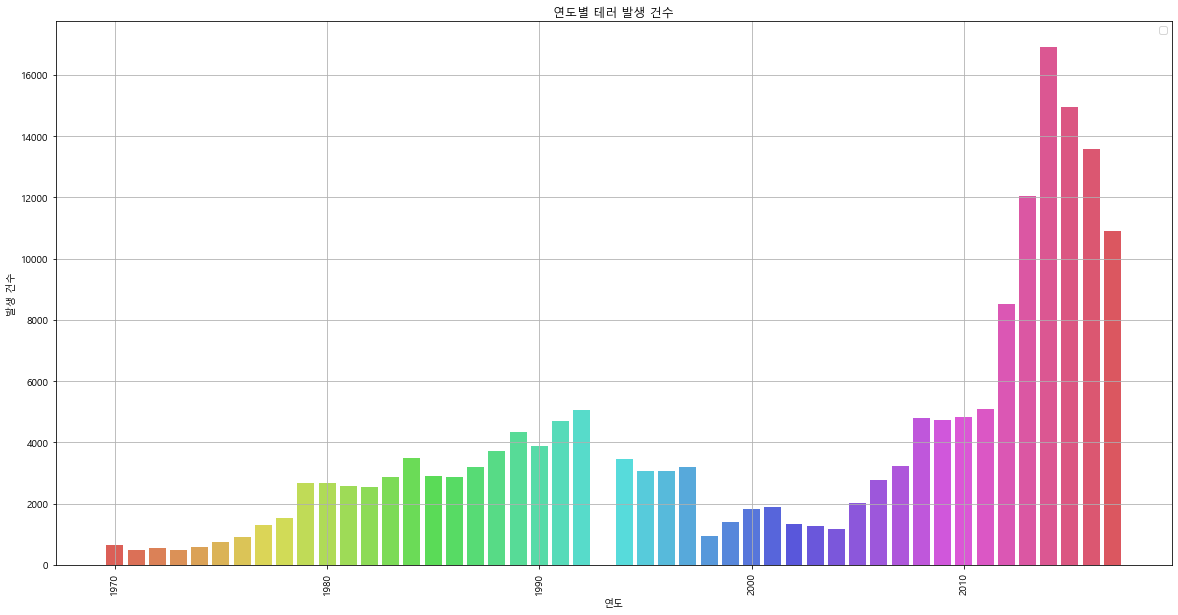

In [17]:
# 시각화 - 1
plt.figure(figsize=(20, 10))
colors = sns.color_palette('hls', len(yearly_data))
plt.bar(yearly_data["연도"], yearly_data["발생건수"], color=colors)
plt.legend()
plt.grid(True)
plt.title('연도별 테러 발생 건수')
plt.xlabel("연도")
plt.ylabel("발생 건수")
plt.xticks(rotation=90)
plt.show()

- 1993년쯤에 내용이 유실된 것으로 보여서 데이터를 다시한번 체크해본다.

In [21]:
yearly_data[yearly_data['연도'] == 1993]

,연도,발생건수


In [22]:
yearly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   연도      47 non-null     int64
 1   발생건수    47 non-null     int64
dtypes: int64(2)
memory usage: 880.0 bytes


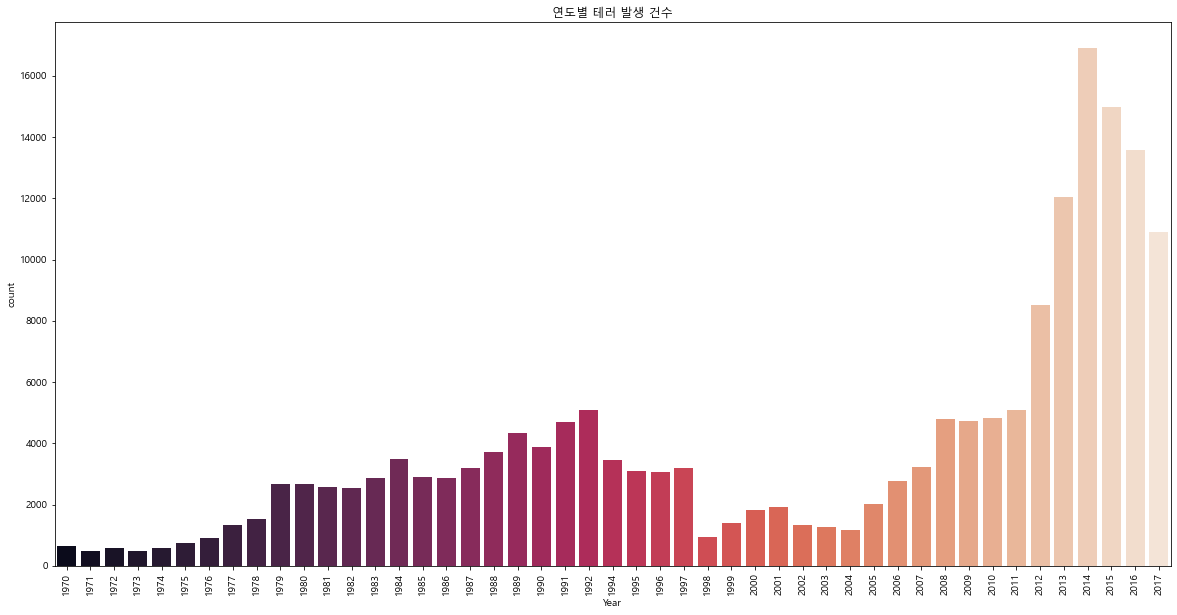

In [35]:
# 시각화 -2 (seaborn 사용)
plt.figure(figsize=(20,10))
sns.countplot("Year", data = raw_data, palette='rocket')
plt.xticks(rotation=90)
plt.title('연도별 테러 발생 건수')
plt.show()

- 위 차트를 보게 되면 2004년도부터 꾸준히증가하기 시작하다가 2011년에서 2012년도부터 갑자기 급속도로 테러 발생률이 증가하는것을 확인할 수 있다. 특히 2014년에는 가장 많은 테러가 일어난 것을 확인할 수 있다,

## 이유 추측

- 일단 원본 파일에서 2014년도의 motive 컬럼 내용을 개략적으로 한번 살펴본다.

In [233]:
tmp = raw_data[raw_data["Motive"].notna()]

In [234]:
tmp_2014 = tmp[tmp["Year"] == 2014]

In [235]:
tmp_2014["Motive"].value_counts()

The specific motive is unknown; however, sources noted that parliamentary elections were scheduled for January 5, 2014. Sources also noted that the opposition advocated for citizens to "resist" the elections.                                                     50
The specific motive is unknown; however, sources noted that the attack on the polling station was meant to disrupt the run-off elections occurring on June 14, 2014.                                                                                                 27
The Taliban claimed responsibility for the incident, stating that the attacks on April 5, 2014 were aimed at disrupting the presidential elections.                                                                                                                  23
The specific motive is unknown; however, sources noted that security forces dismantled a Sunni protest camp outside Ramadi on December 30, 2013, angering members of the Sunni community. Sources also noted tha

- 정확한 내용은 전체적으로 확인해 봐야 알 수 있지만, 위의 내용을 토대로 살펴보게 되면 전체적으로 구체적인 동기는 알려져 있지 않다고 한다. 
하지만 가장 많이 발생한 이유의 동기는 첫째로 국회의원 선거에 반대로 인한 테러가 50건으로 가장 많이 집계된 것을 알 수 있다.(50건)
둘째로 많이 발생한 이유 역시 투표소에 대한 공격이었다. (27건) 세번째는 탈레반이 대통령 선거를 방해하기 위한 공격을 23차례 한것으로 집계되었다. 상위 3건은 어떤 특정한 선거에 의해 일어난 것으로 알수 있었다.
네번째는 보안군이 라마디 외곽의 수니파 시위 캠프를 해체하려고 해서 일어났다고 한다.(13건) 다섯번째 이유 역시 선거에 국회의원 선거가 동기였다고 한다.(15건)
물론 nan 값이 많아 모든 구체적인 동기를 알수는 없지만 대체로 알려진 이유들중 대다수가 선거에 반대해서 일어난 것으로 보인다.
실제로 2014년도 선거 관련 테러로 검색을 해보면 아프가니스탄, 이라크 등의 국가에서 선거가 있을때 연쇄 태러가 많이 일어난 것으로 보인다. 정확한 이유는 알수 없지만 이 시기에 미군이 이라크에서 철수했던것,
그리고 위 국가에서 여러 부정선거 의혹등으로 인해 급진파들의 폭동이 많이 일어낫던것이 이유가 될 수 있을것이라 생각한다.


- 하지만 급속도로 테러가 늘어나기 시작하는것 처럼 보이는 기점은 11년도 이다. 11년도에는 어떤일이 있었나 한번 살펴보도록 하자.

In [236]:
tmp_2011 = tmp = tmp[tmp["Year"] == 2011]
tmp_2011["Motive"].value_counts()

The specific motive for the attack is unknown.                                                                                                  3225
Unknown                                                                                                                                          664
The specific motive for the attack was religious.                                                                                                 31
The attack was carried out because the victim was accused of being a police informer.                                                             21
The attacks occurred on the anniversary of the 2004 suppression of an anti-government protest in Tak Bai in neighboring Narathiwat province.      16
                                                                                                                                                ... 
The specific motive for the attack was to intimidate Hibhib district law enforcement.                     

- 11년도 기점에는 특이하게 대부분의 테러 동기가 명확히 밝혀지지 않고 있다.(3225건) 하지만 기사를 살펴 보게 되면 2011년은 9.11 테러 주범으로 알려져 있는 오사마 빈라덴이 죽은해이다.
명확한 이유는 알 수 없지만 오사마 빈라덴의 죽음이 어느정도 영향을 줬다고 추측할 수 있을것 같다. 이시기에 미국과 아프간 전쟁, 그리고 이라크전 등 여러 상황이 얽혀있었던것 같다. 
테러수가 급등하기 시작한 기점은 2001년 미국 조지부시 대통령이 테러와의 전쟁을 선포한 이후인 2004년도부터라고 볼수도 있을것 같으나, 2011년 이후 이전 최고치를 경신하며 2014년 최고치를 찍었기 때문에 2011년도를 기점으로 정하도록 하자.

---

# 문제 2

- 전 세계 테러 데이터에서 테러가 많이 일어난 국가를 정렬해서 상위 10위 국가를 시각화 해보기

In [43]:
raw_data.head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,casualities
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,Julio Guzman,NaN,MANO-D,Private Citizens & Property,Unknown,NaN,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,Hostage Taking (Kidnapping),0.0,0.0,"Nadine Chaval, daughter",NaN,23rd of September Communist League,Government (Diplomatic),Unknown,NaN,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Employee,NaN,Unknown,Journalists & Media,Unknown,NaN,1.0
3,1970,1,0,Greece,Western Europe,Athens,37.997490,23.762728,Bombing/Explosion,NaN,NaN,U.S. Embassy,NaN,Unknown,Government (Diplomatic),Explosives,NaN,NaN
4,1970,1,0,Japan,East Asia,Fukouka,33.580412,130.396361,Facility/Infrastructure Attack,NaN,NaN,U.S. Consulate,NaN,Unknown,Government (Diplomatic),Incendiary,NaN,NaN


In [44]:
# 상위 10개 국가 뽑아보기 - 개략적으로 보기
raw_data["Country"].value_counts()[:10]

Iraq              24636
Pakistan          14368
Afghanistan       12731
India             11960
Colombia           8306
Philippines        6908
Peru               6096
El Salvador        5320
United Kingdom     5235
Turkey             4292
Name: Country, dtype: int64

- 발생 상위 국가를 보게되면 아까 2014년도에 가장 많은 테러가 일어났던 국가들이 보이는것 같다. 이라크, 파키스탄, 아프가니스탄, 인도에서 10000건이 넘는 테러가 일어난것으로 집계됬다.

In [45]:
top_count_val = pd.DataFrame(raw_data["Country"].value_counts()[:10])
top_count_val.head()

,Country
Iraq,24636
Pakistan,14368
Afghanistan,12731
India,11960
Colombia,8306


In [46]:
top_count_val.reset_index(inplace=True)
top_count_val.head()

,index,Country
0,Iraq,24636
1,Pakistan,14368
2,Afghanistan,12731
3,India,11960
4,Colombia,8306


In [48]:
top_count_val.rename(columns={"index": "Country", "Country": "Count"}, inplace=True)
top_count_val.head()

,Country,Count
0,Iraq,24636
1,Pakistan,14368
2,Afghanistan,12731
3,India,11960
4,Colombia,8306


No handles with labels found to put in legend.


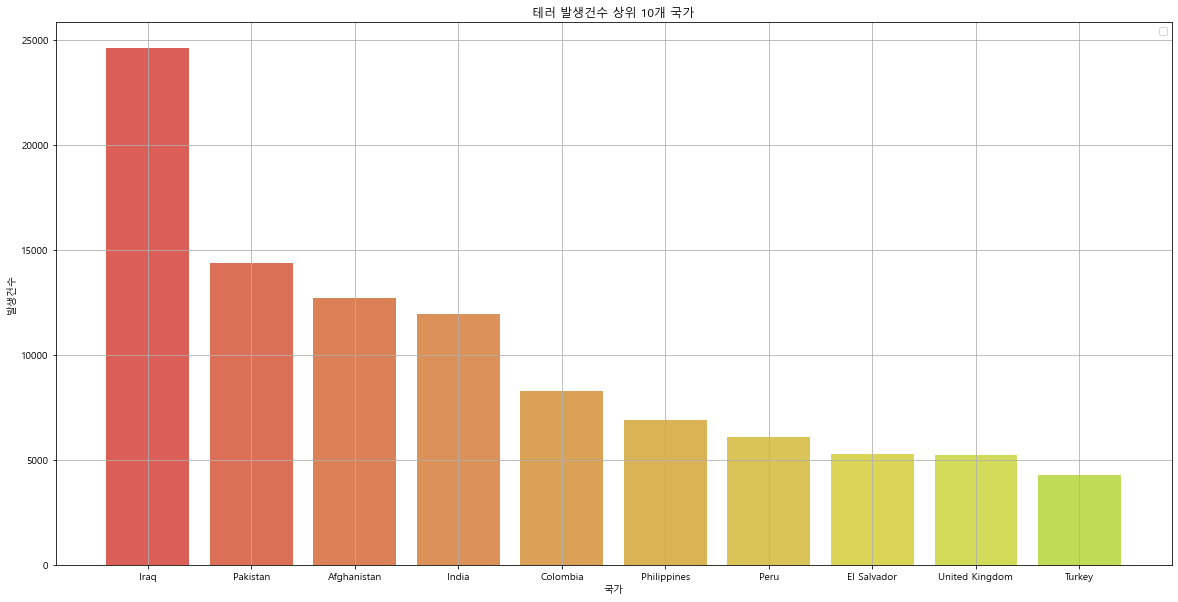

In [49]:
# 시각화 - 1
plt.figure(figsize=(20, 10))
colors = sns.color_palette('hls', len(yearly_data))
plt.bar(top_count_val["Country"], top_count_val["Count"], color=colors)
plt.legend()
plt.grid(True)
plt.title('테러 발생건수 상위 10개 국가')
plt.xlabel("국가")
plt.ylabel("발생건수")
plt.show()

- 바차트로 간단하게 보게되면 일단 이라크가 다른 국가들에 비해 압도적으로 테러가 많이 일어났던 것을 알 수 있다.

In [88]:
top_count_val

,Country,Count
0,Iraq,24636
1,Pakistan,14368
2,Afghanistan,12731
3,India,11960
4,Colombia,8306
5,Philippines,6908
6,Peru,6096
7,El Salvador,5320
8,United Kingdom,5235
9,Turkey,4292


In [104]:
tmp = raw_data["Country"].value_counts()

In [105]:
tmp = pd.DataFrame(tmp)
tmp.head()

,Country
Iraq,24636
Pakistan,14368
Afghanistan,12731
India,11960
Colombia,8306


In [106]:
tmp.reset_index(inplace=True)

In [107]:
tmp.head()

,index,Country
0,Iraq,24636
1,Pakistan,14368
2,Afghanistan,12731
3,India,11960
4,Colombia,8306


In [109]:
tmp = tmp.rename(columns={"index": "Country", "Country": "Count"})
tmp.head()

,Country,Count
0,Iraq,24636
1,Pakistan,14368
2,Afghanistan,12731
3,India,11960
4,Colombia,8306


In [111]:
geo_path = "./world-countries.json"
geo_str = json.load(open(geo_path, encoding='utf-8'))

my_map = folium.Map(location=[34.29966805036661, 43.06849707995499], zoom_start=2)
my_map.choropleth(
    geo_data= geo_str,
    data=tmp,
    columns=["Country", "Count"],
    key_on="feature.properties.name",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="테러 발생수"
)
my_map

- 위 지도를 보게 되면 중동의 이라크,터키 그리고 남미, 인도, 그리고 영국에서 테러횟수가 많이 발생하는 것을 알 수 있다.
검정색은 json 데이터와 매칭되지 않아 색깔이 표시되지 않는것으로 보이며, 특히 짙은 자주색으로 보이는 이라크가 확실히 한눈에 많이 발생한다는 것을 알 수 있을것 같다.

---

# 문제3

- 상위 10개 국가중 사망자수와 부상자수를 시각화 해보기
- 테러횟수, 사망자 수, 부상자 수, 사상자 수 데이터 가져오기

In [112]:
top_count_val

,Country,Count
0,Iraq,24636
1,Pakistan,14368
2,Afghanistan,12731
3,India,11960
4,Colombia,8306
5,Philippines,6908
6,Peru,6096
7,El Salvador,5320
8,United Kingdom,5235
9,Turkey,4292


In [115]:
list(top_count_val["Country"])

['Iraq',
 'Pakistan',
 'Afghanistan',
 'India',
 'Colombia',
 'Philippines',
 'Peru',
 'El Salvador',
 'United Kingdom',
 'Turkey']

In [147]:
# 일단 테러 발생횟수 칼럼명 수정
top_ten_info = top_count_val.rename(columns={"Count": "Terror"})
top_ten_info

,Country,Terror
0,Iraq,24636
1,Pakistan,14368
2,Afghanistan,12731
3,India,11960
4,Colombia,8306
5,Philippines,6908
6,Peru,6096
7,El Salvador,5320
8,United Kingdom,5235
9,Turkey,4292


In [148]:
# 사망자 수, 부상자 수, 사상자 수 가져오기
killed = []
wounded = []
casualities = []

for country in list(top_ten_info["Country"]):
    killed.append(raw_data.loc[raw_data["Country"] == country, "Wounded"].sum())
    wounded.append(raw_data.loc[raw_data["Country"] == country, "Killed"].sum())
    casualities.append(raw_data.loc[raw_data["Country"] == country, "casualities"].sum())



In [149]:
killed

[134690.0,
 42038.0,
 44277.0,
 28980.0,
 10328.0,
 13367.0,
 4078.0,
 5062.0,
 6106.0,
 9899.0]

In [150]:
top_ten_info["Killed"] = killed
top_ten_info["Wounded"] = wounded
top_ten_info["Casualities"] = casualities
top_ten_info

,Country,Terror,Killed,Wounded,Casualities
0,Iraq,24636,134690.0,78589.0,202982.0
1,Pakistan,14368,42038.0,23822.0,64427.0
2,Afghanistan,12731,44277.0,39384.0,80213.0
3,India,11960,28980.0,19341.0,47108.0
4,Colombia,8306,10328.0,14698.0,23767.0
5,Philippines,6908,13367.0,9559.0,22361.0
6,Peru,6096,4078.0,12771.0,16246.0
7,El Salvador,5320,5062.0,12053.0,16181.0
8,United Kingdom,5235,6106.0,3410.0,7591.0
9,Turkey,4292,9899.0,6888.0,16694.0


In [151]:
# 임시 저장
top_ten_info.to_csv("./top_ten_info.csv", sep=",", encoding='utf-8')

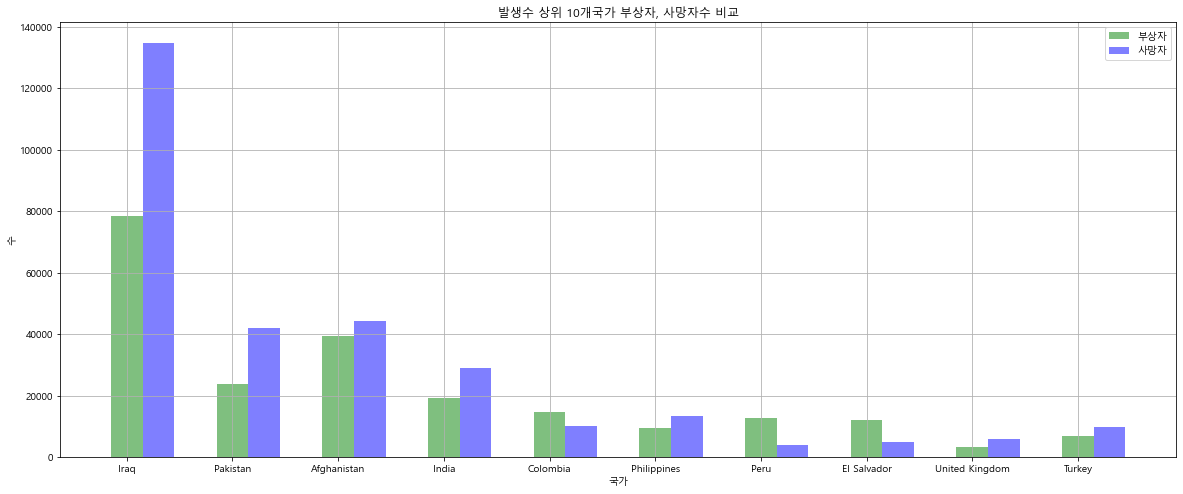

In [160]:
plt.figure(figsize=(20, 8))
x = np.array(range(len(top_ten_info["Country"])))
w = 0.3
label = list(top_ten_info["Country"].values)

plt.bar(x, top_ten_info["Wounded"],
             width = w, 
             color='g', 
             alpha=0.5,
)
x = x + w
plt.bar(x, top_ten_info["Killed"],
             width = w,
             color='b', 
             alpha=0.5,
)

plt.legend(labels=["부상자", "사망자"])
plt.grid(True)
plt.title("발생수 상위 10개국가 부상자, 사망자수 비교")
plt.xlabel("국가")
plt.xticks(np.arange(len(label)), label)
plt.ylabel("수")
plt.show()

- 위 차트를 보게되면 대체로 사망자수가 부상자수보다 많은 경향을 보이고 있다. 하지만 콜림비아나 페루, 엘살바도르 같은 경우는 부상자수가 더 많은 모습을 보이고 있다.
다시 한번 사망자 수가 더 많은 국가에 대해 살펴보도록 하자

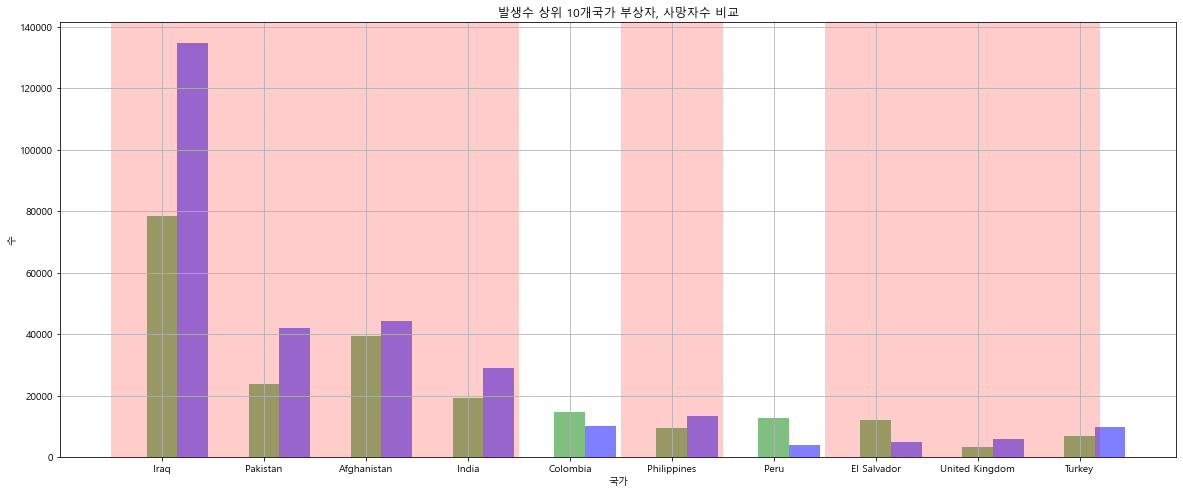

In [170]:
# 시각화 -2 
plt.figure(figsize=(20, 8))
x = np.array(range(len(top_ten_info["Country"])))
w = 0.3
label = list(top_ten_info["Country"].values)

plt.bar(x, top_ten_info["Wounded"],
             width = w, 
             color='g', 
             alpha=0.5,
)
x = x + w
plt.bar(x, top_ten_info["Killed"],
             width = w,
             color='b', 
             alpha=0.5,
)

plt.axvspan(-0.5, 3.5, facecolor='red', alpha=0.2)
plt.axvspan(4.5, 5.5, facecolor='red', alpha=0.2)
plt.axvspan(6.5, 9.2, facecolor='red', alpha=0.2)

plt.grid(True)
plt.title("발생수 상위 10개국가 부상자, 사망자수 비교")
plt.xlabel("국가")
plt.xticks(np.arange(len(label)), label)
plt.ylabel("수")
plt.show()

- 위 그래프에서 구간이 빨갛게 칠해진 부분은 사망자수가더 많은 경우 이다. 그래프만 봐도 알 수 있듯이 테러가 일어나게 되면 대체로 부상을 당하기보단 거의 사망에 이르는 경우가 많아 심각하다고 할 수 있을것 같다.

## 테러 횟수와 사상자 수 비교해보기

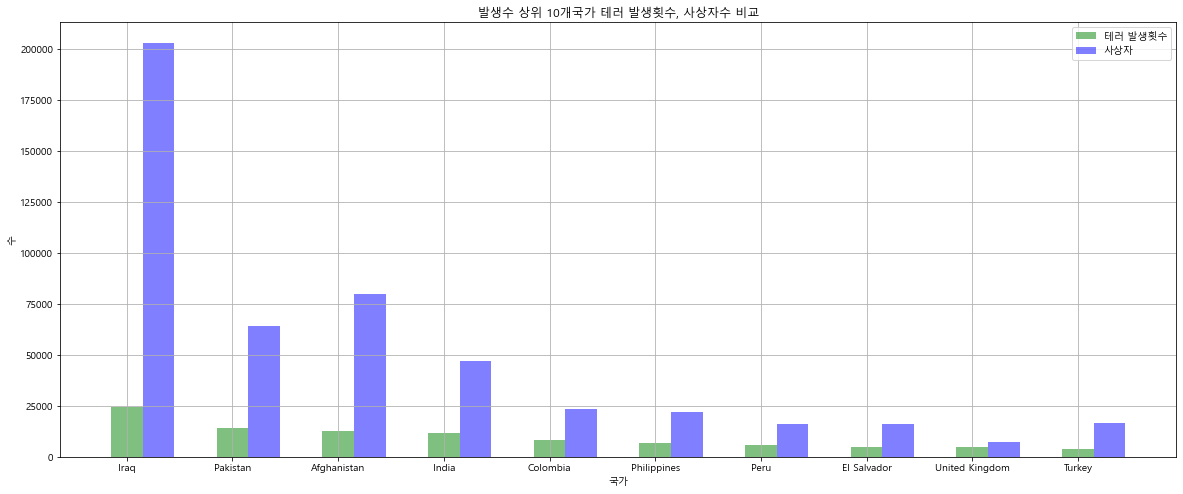

In [171]:
plt.figure(figsize=(20, 8))
x = np.array(range(len(top_ten_info["Country"])))
w = 0.3
label = list(top_ten_info["Country"].values)

plt.bar(x, top_ten_info["Terror"],
             width = w, 
             color='g', 
             alpha=0.5,
)
x = x + w
plt.bar(x, top_ten_info["Casualities"],
             width = w,
             color='b', 
             alpha=0.5,
)

plt.legend(labels=["테러 발생횟수", "사상자"])
plt.grid(True)
plt.title("발생수 상위 10개국가 테러 발생횟수, 사상자수 비교")
plt.xlabel("국가")
plt.xticks(np.arange(len(label)), label)
plt.ylabel("수")
plt.show()

- 테러 발생 횟수에 비해 사상자수가 대체로 월등히 높은 모습을 보여주므로 사상자 수 / 테러발생 횟수로 다시 한번 시각화 해보도록 하자.

In [172]:
top_ten_info["Casualities/Terror"] = top_ten_info["Casualities"] / top_ten_info["Terror"]

No handles with labels found to put in legend.


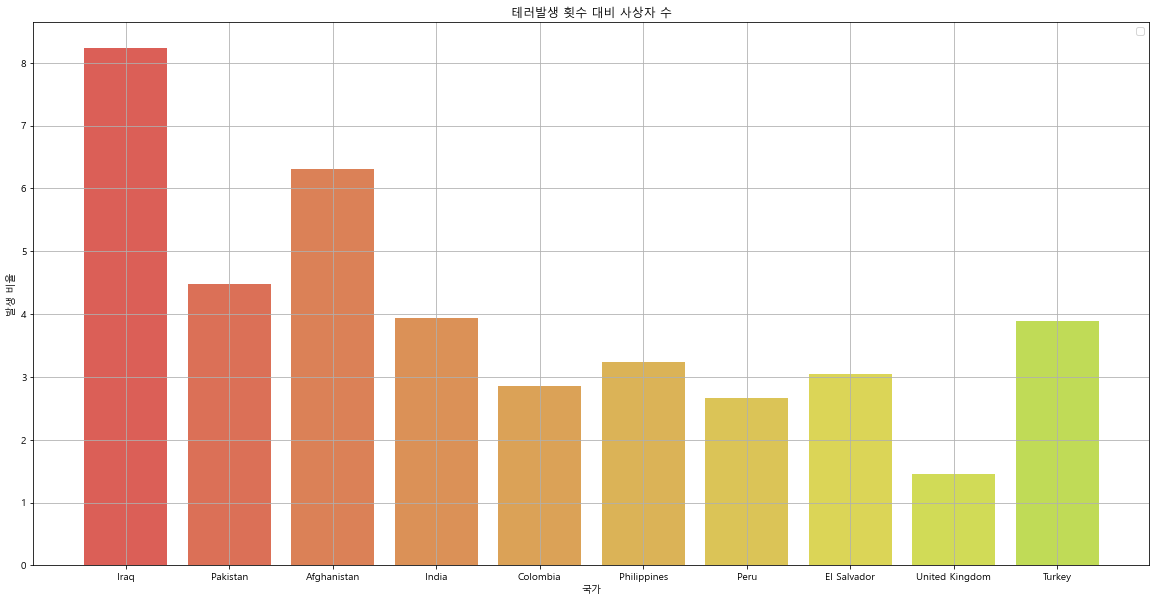

In [173]:
plt.figure(figsize=(20, 10))
colors = sns.color_palette('hls', len(yearly_data))
plt.bar(top_ten_info["Country"], top_ten_info["Casualities/Terror"], color=colors)
plt.legend()
plt.grid(True)
plt.title('테러발생 횟수 대비 사상자 수')
plt.xlabel("국가")
plt.ylabel("발생 비율")
plt.show()

- 위 데이터를 보게 되면 아래 x축의 순서는 테러가 많이 발생하는 국가 순서로 정렬이 되어있는 상태이다.
이라크의 경우 발생횟수, 그리고 사상자 수가 압도적으로 다른 발생 국가에 비해높은 결과를 보여주고 있다.
대체로 발생횟수가 많을 수록 사상자수 비율도 높은 것으로 나오지만, 어떠한 특별한 관계가 보이진 않는 것 같다.

---

# 문제 4

- 중동&북아프라카, 남아시아, 남아메리카, 서유럽, 남동아시아, 동유럽, 북아메리카, 동아시아 지역으로 구분
- 공격형태, 사망자수, 사상자수 
- 지역별로 위 데이터들의 시각화

In [176]:
raw_data.head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,casualities
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,Julio Guzman,NaN,MANO-D,Private Citizens & Property,Unknown,NaN,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,Hostage Taking (Kidnapping),0.0,0.0,"Nadine Chaval, daughter",NaN,23rd of September Communist League,Government (Diplomatic),Unknown,NaN,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Employee,NaN,Unknown,Journalists & Media,Unknown,NaN,1.0
3,1970,1,0,Greece,Western Europe,Athens,37.997490,23.762728,Bombing/Explosion,NaN,NaN,U.S. Embassy,NaN,Unknown,Government (Diplomatic),Explosives,NaN,NaN
4,1970,1,0,Japan,East Asia,Fukouka,33.580412,130.396361,Facility/Infrastructure Attack,NaN,NaN,U.S. Consulate,NaN,Unknown,Government (Diplomatic),Incendiary,NaN,NaN


In [203]:
# 사망자, 부상자, 사상자 수 정리
region_info = raw_data.pivot_table(index=["Region", "AttackType"], values=["Killed", "Wounded", "casualities"],aggfunc='sum')
region_info

Killed  Wounded  \
Region                AttackType                                             
Australasia & Oceania Armed Assault                          78.0     87.0   
                      Assassination                          34.0      9.0   
                      Bombing/Explosion                       9.0     77.0   
                      Facility/Infrastructure Attack          0.0     13.0   
                      Hijacking                               0.0      0.0   
...                                                           ...      ...   
Western Europe        Hijacking                             133.0     66.0   
                      Hostage Taking (Barricade Incident)   170.0    389.0   
                      Hostage Taking (Kidnapping)            77.0     33.0   
                      Unarmed Assault                        53.0    435.0   
                      Unknown                                30.0    126.0   

                                                           casualities  
Region                AttackType                                        
Australasia & Oceania Armed Assault                              164.0  
                      Assassination                               43.0  
                      Bombing/Explosion                           86.0  
                      Facility/Infrastructure Attack              13.0  
                      Hijacking                                    0.0  
...                                                                ...  
Western Europe        Hijacking                                  152.0  
                      Hostage Taking (Barricade Incident)        533.0  
                      Hostage Taking (Kidnapping)                 76.0  
                      Unarmed Assault                            478.0  
                      Unknown                                    147.0  

[108 rows x 3 columns]

In [204]:
region_list = ['Middle East & North Africa', 'South Asia', 'South America', 'Western Europe', 'Southeast Asia', 'Eastern Europe', 'North America', 'East Asia']

In [205]:
# 조사할 국가들만 필터링
region_info = region_info.loc[region_list]
region_info

Killed  \
Region                     AttackType                                     
Middle East & North Africa Armed Assault                        26201.0   
                           Assassination                         4774.0   
                           Bombing/Explosion                    81183.0   
                           Facility/Infrastructure Attack         802.0   
                           Hijacking                              124.0   
...                                                                 ...   
East Asia                  Hijacking                                9.0   
                           Hostage Taking (Barricade Incident)     19.0   
                           Hostage Taking (Kidnapping)              4.0   
                           Unarmed Assault                         26.0   
                           Unknown                                  8.0   

                                                                 Wounded  \
Region                     AttackType                                      
Middle East & North Africa Armed Assault                         14894.0   
                           Assassination                          4521.0   
                           Bombing/Explosion                    187839.0   
                           Facility/Infrastructure Attack          618.0   
                           Hijacking                                73.0   
...                                                                  ...   
East Asia                  Hijacking                                17.0   
                           Hostage Taking (Barricade Incident)      26.0   
                           Hostage Taking (Kidnapping)               4.0   
                           Unarmed Assault                        7040.0   
                           Unknown                                 107.0   

                                                                casualities  
Region                     AttackType                                        
Middle East & North Africa Armed Assault                            38136.0  
                           Assassination                             9167.0  
                           Bombing/Explosion                       260518.0  
                           Facility/Infrastructure Attack            1239.0  
                           Hijacking                                  189.0  
...                                                                     ...  
East Asia                  Hijacking                                   26.0  
                           Hostage Taking (Barricade Incident)         45.0  
                           Hostage Taking (Kidnapping)                  8.0  
                           Unarmed Assault                           7065.0  
                           Unknown                                    115.0  

[72 rows x 3 columns]

In [191]:
# attacktype 조사
raw_data.loc[raw_data["Region"] == "Middle East & North Africa", "AttackType"].value_counts()

Bombing/Explosion                      30908
Armed Assault                           9273
Assassination                           4206
Hostage Taking (Kidnapping)             2666
Unknown                                 1891
Facility/Infrastructure Attack          1115
Unarmed Assault                          177
Hijacking                                138
Hostage Taking (Barricade Incident)      100
Name: AttackType, dtype: int64

- 위데이터는 중동&북아프리카에서 테러 공격수단으로 사용된 방법들의 수를 간략하게 표시한 것이다.
결과를 보면 대부분 폭팔물을 이용한 경우가 많았고, 그다음 많은것이 무장폭행, 암살, 인질 납치, 시설/ 인프라 공격을 하는 유형으로 나타난다.
눈에 띄는점은 알려지지 않은 공격방식이 4위로 집계되었다는 점이다.
다른국가들도 차례대로 살펴보도록 하자.

In [192]:
raw_data.loc[raw_data["Region"] == "South Asia", "AttackType"].value_counts()

Bombing/Explosion                      21246
Armed Assault                          11404
Assassination                           4301
Hostage Taking (Kidnapping)             3277
Facility/Infrastructure Attack          2189
Unknown                                 2021
Unarmed Assault                          323
Hostage Taking (Barricade Incident)      120
Hijacking                                 93
Name: AttackType, dtype: int64

= 남아시아 역시 비슷한 결과를 보인다. 폭팔물, 무장폭행, 암살, 인질 납치, 시설/ 인프라 공격이 많이발생하고 있다. 특히 인질납치의 경우 아동을 납치하는 것으로 보인다.

In [193]:
raw_data.loc[raw_data["Region"] == "South America", "AttackType"].value_counts()

Bombing/Explosion                      9039
Armed Assault                          3875
Assassination                          2745
Hostage Taking (Kidnapping)            1414
Facility/Infrastructure Attack          803
Unknown                                 754
Hostage Taking (Barricade Incident)     234
Hijacking                                67
Unarmed Assault                          47
Name: AttackType, dtype: int64

마찬 가지 결과이다.

In [194]:
raw_data.loc[raw_data["Region"] == "Southeast Asia", "AttackType"].value_counts()

Bombing/Explosion                      4818
Armed Assault                          4022
Assassination                          1369
Facility/Infrastructure Attack          948
Hostage Taking (Kidnapping)             744
Unknown                                 433
Hostage Taking (Barricade Incident)      67
Hijacking                                59
Unarmed Assault                          25
Name: AttackType, dtype: int64

In [219]:
region_info

Killed  \
Region                     AttackType                                     
Middle East & North Africa Armed Assault                        26201.0   
                           Assassination                         4774.0   
                           Bombing/Explosion                    81183.0   
                           Facility/Infrastructure Attack         802.0   
                           Hijacking                              124.0   
...                                                                 ...   
East Asia                  Hijacking                                9.0   
                           Hostage Taking (Barricade Incident)     19.0   
                           Hostage Taking (Kidnapping)              4.0   
                           Unarmed Assault                         26.0   
                           Unknown                                  8.0   

                                                                 Wounded  \
Region                     AttackType                                      
Middle East & North Africa Armed Assault                         14894.0   
                           Assassination                          4521.0   
                           Bombing/Explosion                    187839.0   
                           Facility/Infrastructure Attack          618.0   
                           Hijacking                                73.0   
...                                                                  ...   
East Asia                  Hijacking                                17.0   
                           Hostage Taking (Barricade Incident)      26.0   
                           Hostage Taking (Kidnapping)               4.0   
                           Unarmed Assault                        7040.0   
                           Unknown                                 107.0   

                                                                casualities  
Region                     AttackType                                        
Middle East & North Africa Armed Assault                            38136.0  
                           Assassination                             9167.0  
                           Bombing/Explosion                       260518.0  
                           Facility/Infrastructure Attack            1239.0  
                           Hijacking                                  189.0  
...                                                                     ...  
East Asia                  Hijacking                                   26.0  
                           Hostage Taking (Barricade Incident)         45.0  
                           Hostage Taking (Kidnapping)                  8.0  
                           Unarmed Assault                           7065.0  
                           Unknown                                    115.0  

[72 rows x 3 columns]

In [228]:
tmp = region_info.reset_index()
tmp

,Region,AttackType,Killed,Wounded,casualities
0,Middle East & North Africa,Armed Assault,26201.0,14894.0,38136.0
1,Middle East & North Africa,Assassination,4774.0,4521.0,9167.0
2,Middle East & North Africa,Bombing/Explosion,81183.0,187839.0,260518.0
3,Middle East & North Africa,Facility/Infrastructure Attack,802.0,618.0,1239.0
4,Middle East & North Africa,Hijacking,124.0,73.0,189.0
...,...,...,...,...,...
67,East Asia,Hijacking,9.0,17.0,26.0
68,East Asia,Hostage Taking (Barricade Incident),19.0,26.0,45.0
69,East Asia,Hostage Taking (Kidnapping),4.0,4.0,8.0
70,East Asia,Unarmed Assault,26.0,7040.0,7065.0


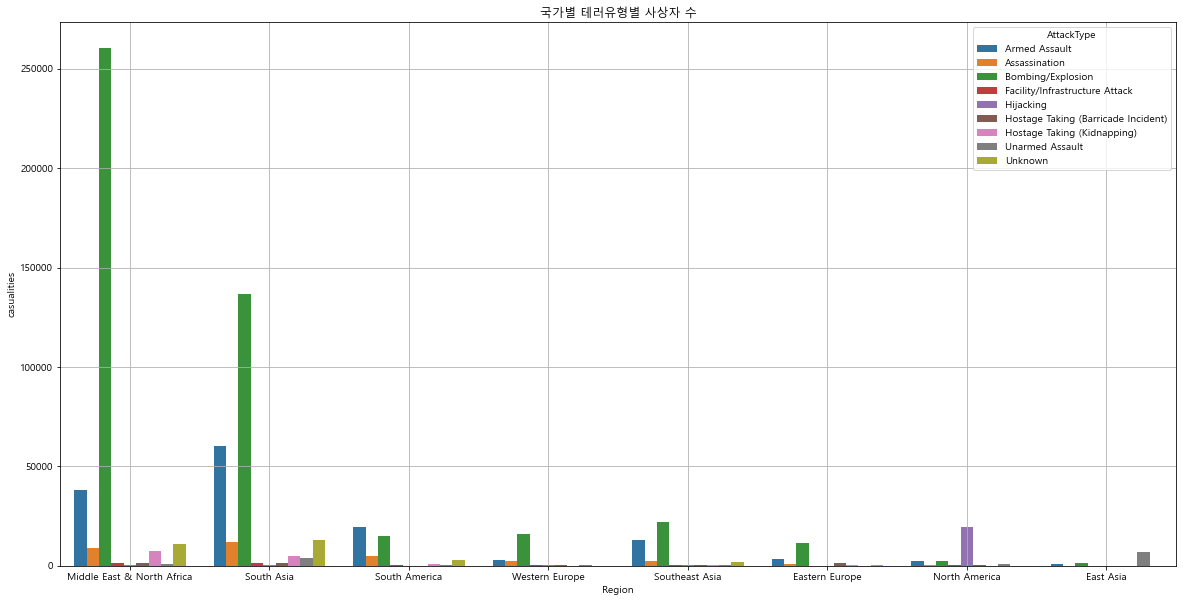

In [232]:
plt.figure(figsize=(20,10))
sns.barplot(x="Region", y="casualities", data=tmp, hue="AttackType")
plt.title('국가별 테러유형별 사상자 수')
plt.grid(True)
plt.show()

- 위 데이터를 보게되면 문제에서 주어진 국가별로 총 사상자수에서 테러 유형별 건수를 확인할 수 있다. legend에서 녹색은 폭팔물 유형 테러를 나타내고 있는데
모든 국가에서 폭팔물 유형에 의한 테러가 가장 많이 나타나는 것을 볼 수 있따. 또한 그 다음 무장폭행이 많은 것을 관찰할 수 있다. 북아메리카의 경우 특이하게 바리케이트 납치 사건이 많이 집계되는 결과를 나타내고 있다.

---

# 문제 5

- 데이터 = 문제 4번에서 정리한 국가들
- 문제 1번에서 특정 지은 시기 = 2011년도(이유: 실제로 증가하기 시작하는 해는 2004년이나 2011년도부터 급격히 증가하여 2014년도에 최고치를 찍었기 때문)

In [240]:
data_2011 = raw_data[raw_data["Year"] == 2011]
data_2011.tail()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,casualities
104773,2011,12,31,Iraq,Middle East & North Africa,Khan Bani Saad,33.571807,44.536067,Armed Assault,5.0,0.0,5 Sahwa Militia members,12/31/2011: Five members of the Sahwa militia ...,Al-Qaida in Iraq,Terrorists/Non-State Militia,Firearms,Unknown,5.0
104774,2011,12,31,Pakistan,South Asia,Landi Kotal,34.110325,71.163803,Bombing/Explosion,2.0,13.0,Civilians,12/31/2011: Two children were killed and thirt...,Unknown,Private Citizens & Property,Explosives,Unknown,15.0
104775,2011,12,31,Iraq,Middle East & North Africa,Kirkuk,35.452110,44.375465,Bombing/Explosion,0.0,1.0,Civilian,12/31/2011: A civilian was wounded when a stic...,Unknown,Private Citizens & Property,Explosives,Unknown,1.0
104776,2011,12,31,Pakistan,South Asia,Boya,32.945308,69.897046,Bombing/Explosion,2.0,NaN,2 Pakistani soldiers,"12/31/2011: A remote-triggered, homemade roads...",Tehrik-i-Taliban Pakistan (TTP),Military,Explosives,Unknown,NaN
104777,2011,12,31,Pakistan,South Asia,Landi Kotal,34.110325,71.163803,Bombing/Explosion,2.0,4.0,Salamat Khan,12/31/2011: A bomb detonated outside the home ...,Unknown,Private Citizens & Property,Explosives,Unknown,6.0


In [241]:
pivot_2011 = data_2011.pivot_table(index=["Region", "AttackType"], values=["Killed", "Wounded", "casualities"],aggfunc='sum')
pivot_2011

Killed  Wounded  \
Region                      AttackType                                        
Central America & Caribbean Armed Assault                      2.0      0.0   
Central Asia                Armed Assault                      2.0      0.0   
                            Bombing/Explosion                 11.0      3.0   
East Asia                   Armed Assault                     19.0     32.0   
                            Bombing/Explosion                  0.0      0.0   
...                                                            ...      ...   
Western Europe              Armed Assault                     74.0     68.0   
                            Bombing/Explosion                  9.0     24.0   
                            Facility/Infrastructure Attack     0.0      3.0   
                            Hijacking                          0.0      0.0   
                            Unarmed Assault                    0.0      1.0   

                                                            casualities  
Region                      AttackType                                   
Central America & Caribbean Armed Assault                           2.0  
Central Asia                Armed Assault                           2.0  
                            Bombing/Explosion                      14.0  
East Asia                   Armed Assault                          51.0  
                            Bombing/Explosion                       0.0  
...                                                                 ...  
Western Europe              Armed Assault                         142.0  
                            Bombing/Explosion                      33.0  
                            Facility/Infrastructure Attack          3.0  
                            Hijacking                               0.0  
                            Unarmed Assault                         1.0  

[61 rows x 3 columns]

In [244]:
pivot_2011 = pivot_2011.loc[region_list]
pivot_2011

Killed  \
Region                     AttackType                                    
Middle East & North Africa Armed Assault                         648.0   
                           Assassination                         142.0   
                           Bombing/Explosion                    1713.0   
                           Facility/Infrastructure Attack         14.0   
                           Hijacking                               1.0   
                           Hostage Taking (Barricade Incident)     0.0   
                           Hostage Taking (Kidnapping)            35.0   
                           Unarmed Assault                         1.0   
                           Unknown                                97.0   
South Asia                 Armed Assault                         999.0   
                           Assassination                         248.0   
                           Bombing/Explosion                    2108.0   
                           Facility/Infrastructure Attack         18.0   
                           Hijacking                               1.0   
                           Hostage Taking (Barricade Incident)     7.0   
                           Hostage Taking (Kidnapping)           186.0   
                           Unarmed Assault                         2.0   
                           Unknown                               156.0   
South America              Armed Assault                          14.0   
                           Assassination                           2.0   
                           Bombing/Explosion                      15.0   
                           Facility/Infrastructure Attack          0.0   
                           Hijacking                               0.0   
                           Hostage Taking (Kidnapping)             9.0   
                           Unknown                                 3.0   
Western Europe             Armed Assault                          74.0   
                           Bombing/Explosion                       9.0   
                           Facility/Infrastructure Attack          0.0   
                           Hijacking                               0.0   
                           Unarmed Assault                         0.0   
Southeast Asia             Armed Assault                         186.0   
                           Assassination                          25.0   
                           Bombing/Explosion                      73.0   
                           Facility/Infrastructure Attack          3.0   
                           Hijacking                               0.0   
                           Hostage Taking (Kidnapping)             3.0   
                           Unarmed Assault                         2.0   
                           Unknown                                 7.0   
Eastern Europe             Armed Assault                          55.0   
                           Assassination                          32.0   
                           Bombing/Explosion                      87.0   
                           Facility/Infrastructure Attack          0.0   
                           Hostage Taking (Kidnapping)             0.0   
                           Unknown                                 0.0   
North America              Armed Assault                           0.0   
                           Bombing/Explosion                       0.0   
                           Facility/Infrastructure Attack          0.0   
                           Hostage Taking (Kidnapping)             0.0   
East Asia                  Armed Assault                          19.0   
                           Bombing/Explosion                       0.0   

                                                                Wounded  \
Region                     AttackType                                     
Middle East & North Africa Armed Assault                         

In [245]:
tmp_2011 = pivot_2011.reset_index()
tmp_2011

,Region,AttackType,Killed,Wounded,casualities
0,Middle East & North Africa,Armed Assault,648.0,336.0,935.0
1,Middle East & North Africa,Assassination,142.0,375.0,515.0
2,Middle East & North Africa,Bombing/Explosion,1713.0,5240.0,6942.0
3,Middle East & North Africa,Facility/Infrastructure Attack,14.0,22.0,35.0
4,Middle East & North Africa,Hijacking,1.0,0.0,1.0
5,Middle East & North Africa,Hostage Taking (Barricade Incident),0.0,0.0,0.0
6,Middle East & North Africa,Hostage Taking (Kidnapping),35.0,3.0,38.0
7,Middle East & North Africa,Unarmed Assault,1.0,5.0,6.0
8,Middle East & North Africa,Unknown,97.0,108.0,195.0
9,South Asia,Armed Assault,999.0,731.0,1698.0


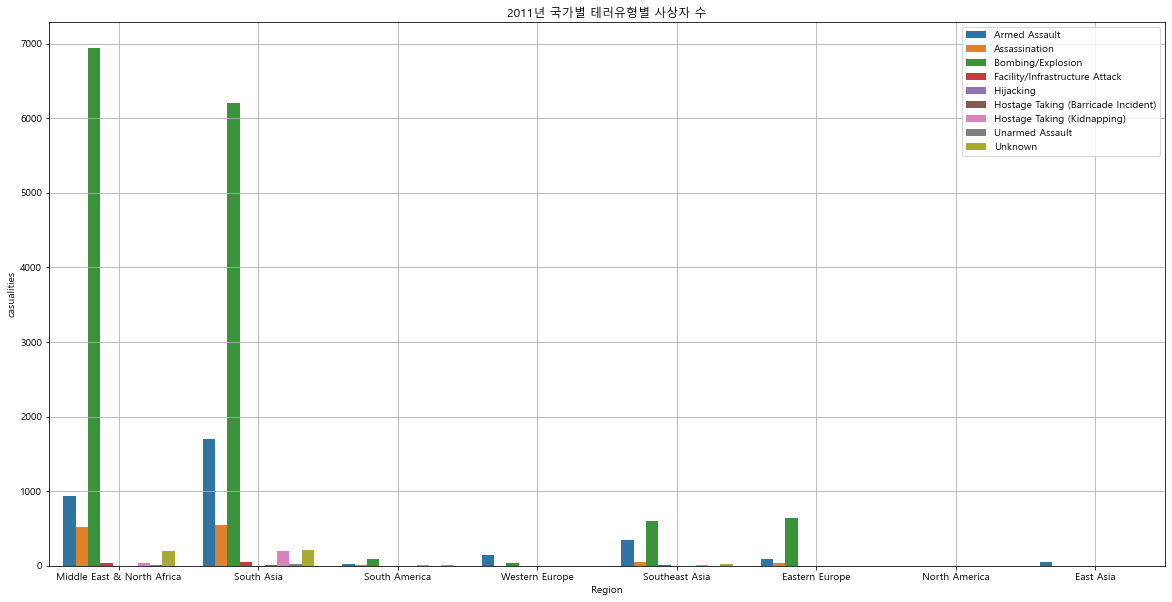

In [249]:
plt.figure(figsize=(20,10))
sns.barplot(x="Region", y="casualities", data=tmp_2011, hue="AttackType")
plt.title('2011년 국가별 테러유형별 사상자 수')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

- 일단 위 데이터를보게되면 전체 기준으로 잡았을 때와 비슷하게 중동&남아프리카쪽에서 가장 많은 사상자 수가 나온것을 확인할 수 있다.
하지만 이전과 다르게 눈에 띄는것은 남아시아쪽에서 폭팔물에 의한 테러로 인한 사상자수가 거의 이라크전과 비슷한 수치로 발생했다는 점이 눈에 띈다.

- 실제로 2011년도 당시 남아시아 국가인 인도에서 발생한 테러 기사를 찾아보면 여러 테러 기사를 찾아볼수 있다. 예를들어 뭄바이 연쇄 테러같은 경우
폭팔물 테러로 125명이 사망한 적도 있다고 한다. 위에서 지도 시각화를 통해 살펴봣듯이 이라크 다음으로 인도도 테러가 많이 발생하는 국가라는 결과가 나왔다.
인도의 경우는 종교적인 갈등으로 많은 테러가 발생하는것으로 추측된다. 특히 2011년도 경우 남아시아에서 열리는 크리켓 월드컵 개최 부근 당시 여러 테러 위협이 많았던 것으로 자료가 나오는것 같다.


---

# 문제 6

- 중동&북아프리카, 남아시아, 서유럽, 남동아시아, 동유럽, 북아메리카, 동아시아로 구분
- 70, 80, 90, 2000년대, 2010년대로 구분하여 특성 비교해보기

In [284]:
# 지역 리스트 재할당
number_six = ['Middle East & North Africa', 'South Asia', 'Western Europe', 'Southeast Asia', 'Eastern Europe', 'North America', 'East Asia']

In [298]:
period_raw = raw_data.pivot_table(index=["Region", "Year"], values=["Killed", "Wounded", "casualities"],aggfunc='sum')
period_raw.head()

Killed  Wounded  casualities
Region                Year                              
Australasia & Oceania 1970     0.0      0.0          0.0
                      1971     0.0      0.0          0.0
                      1972     1.0      0.0          1.0
                      1973     0.0      0.0          0.0
                      1974     0.0      0.0          0.0

In [299]:
# 조사할 국가들로 필터링
period_raw = period_raw.loc[number_six]

In [300]:
# 국가 별로 잘 필터링 됫나 확인
period_raw.reset_index(level=1, inplace=True)
period_raw.head()

,Year,Killed,Wounded,casualities
Region,,,,
Middle East & North Africa,1970,1.0,5.0,6.0
Middle East & North Africa,1971,7.0,11.0,18.0
Middle East & North Africa,1972,33.0,83.0,116.0
Middle East & North Africa,1973,7.0,18.0,25.0
Middle East & North Africa,1974,81.0,168.0,207.0


In [319]:
region = list(period_raw.index.unique())
region

['Middle East & North Africa',
 'South Asia',
 'Western Europe',
 'Southeast Asia',
 'Eastern Europe',
 'North America',
 'East Asia']

In [302]:
period_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, Middle East & North Africa to East Asia
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         324 non-null    int64  
 1   Killed       324 non-null    float64
 2   Wounded      324 non-null    float64
 3   casualities  324 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 20.8+ KB


In [303]:
period_raw_new = raw_data.pivot_table(index="Region", values=["Killed", "Wounded", "casualities"],aggfunc='sum')
period_raw_new = period_raw_new.loc[number_six]
period_raw_new

,Killed,Wounded,casualities
Region,,,
Middle East & North Africa,137642.0,214308.0,329807.0
South Asia,101319.0,141360.0,234366.0
Western Europe,6694.0,18332.0,22778.0
Southeast Asia,15637.0,26259.0,40841.0
Eastern Europe,7415.0,12045.0,18239.0
North America,4916.0,21531.0,26398.0
East Asia,1152.0,9213.0,10003.0


In [304]:
period_raw_new.reset_index(inplace=True)
period_raw_new.head()

,Region,Killed,Wounded,casualities
0,Middle East & North Africa,137642.0,214308.0,329807.0
1,South Asia,101319.0,141360.0,234366.0
2,Western Europe,6694.0,18332.0,22778.0
3,Southeast Asia,15637.0,26259.0,40841.0
4,Eastern Europe,7415.0,12045.0,18239.0


In [305]:
period_raw_new

,Region,Killed,Wounded,casualities
0,Middle East & North Africa,137642.0,214308.0,329807.0
1,South Asia,101319.0,141360.0,234366.0
2,Western Europe,6694.0,18332.0,22778.0
3,Southeast Asia,15637.0,26259.0,40841.0
4,Eastern Europe,7415.0,12045.0,18239.0
5,North America,4916.0,21531.0,26398.0
6,East Asia,1152.0,9213.0,10003.0


In [360]:
# 사상자 연도별 정리
casualities1 = []
casualities2 = []
casualities3 = []
casualities4 = []
casualities5 = []

date1 = list(range(1970,1980))
date2 = list(range(1980,1990))
date3 = list(range(1990,2000))
date4 = list(range(2000,2010))
date5 = list(range(2010,2018))

region = list(period_raw.index.unique())

for region in region:
    tmp = period_raw[period_raw.index==region]
    tmp = tmp.set_index("Year")
    # 1970
    sum1 = 0
    for year in date1:
        try:
            data = tmp.loc[year, "casualities"]
            if data != np.nan:
                sum1 += data
        except:
            sum1 += 0
    casualities1.append(sum1)

    # 1980
    sum2 = 0
    for year in date2:
        try:
            data = tmp.loc[year, "casualities"]
            if data != np.nan:
                sum2 += data
        except:
            sum2 += 0
    casualities2.append(sum2)

    # 1990
    sum3 = 0
    for year in date3:
        try:
            data = tmp.loc[year, "casualities"]
            if data != np.nan:
                sum3 += data
        except:
            sum3 += 0
    casualities3.append(sum3)

    # 2000
    sum4 = 0
    for year in date4:
        try:
            data = tmp.loc[year, "casualities"]
            if data != np.nan:
                sum4 += data
        except:
            sum4 += 0
    casualities4.append(sum4)

    #2010
    sum5 = 0
    for year in date5:
        try:
            data = tmp.loc[year, "casualities"]
            if data != np.nan:
                sum5 += data
        except:
            sum5 += 0
    casualities5.append(sum5)

    


In [361]:
period_raw_new["70년대"] = casualities1
period_raw_new["80년대"] = casualities2
period_raw_new["90년대"] = casualities3
period_raw_new["2000년대"] = casualities4
period_raw_new["2010년대"] = casualities5

In [362]:
period_raw_new

,Region,Killed,Wounded,casualities,70년대,80년대,90년대,2000년대,2010년대
0,Middle East & North Africa,137642.0,214308.0,329807.0,3582.0,15961.0,26854.0,88833.0,194577.0
1,South Asia,101319.0,141360.0,234366.0,196.0,19848.0,38942.0,56281.0,119099.0
2,Western Europe,6694.0,18332.0,22778.0,3739.0,7995.0,4159.0,4078.0,2807.0
3,Southeast Asia,15637.0,26259.0,40841.0,1362.0,7274.0,7110.0,11427.0,13668.0
4,Eastern Europe,7415.0,12045.0,18239.0,53.0,91.0,3438.0,7105.0,7552.0
5,North America,4916.0,21531.0,26398.0,909.0,1384.0,2009.0,19890.0,2206.0
6,East Asia,1152.0,9213.0,10003.0,26.0,163.0,7919.0,502.0,1393.0


In [363]:
# 구간별로 맞게 잡혔는지 검산
period_raw_new["합계"] = period_raw_new["70년대"] + period_raw_new["80년대"] + period_raw_new["90년대"] + period_raw_new["2000년대"] + period_raw_new["2010년대"]

In [365]:
period_raw_new

,Region,Killed,Wounded,casualities,70년대,80년대,90년대,2000년대,2010년대,합계
0,Middle East & North Africa,137642.0,214308.0,329807.0,3582.0,15961.0,26854.0,88833.0,194577.0,329807.0
1,South Asia,101319.0,141360.0,234366.0,196.0,19848.0,38942.0,56281.0,119099.0,234366.0
2,Western Europe,6694.0,18332.0,22778.0,3739.0,7995.0,4159.0,4078.0,2807.0,22778.0
3,Southeast Asia,15637.0,26259.0,40841.0,1362.0,7274.0,7110.0,11427.0,13668.0,40841.0
4,Eastern Europe,7415.0,12045.0,18239.0,53.0,91.0,3438.0,7105.0,7552.0,18239.0
5,North America,4916.0,21531.0,26398.0,909.0,1384.0,2009.0,19890.0,2206.0,26398.0
6,East Asia,1152.0,9213.0,10003.0,26.0,163.0,7919.0,502.0,1393.0,10003.0


## 연도별 > 구역별로 시각화 해보기

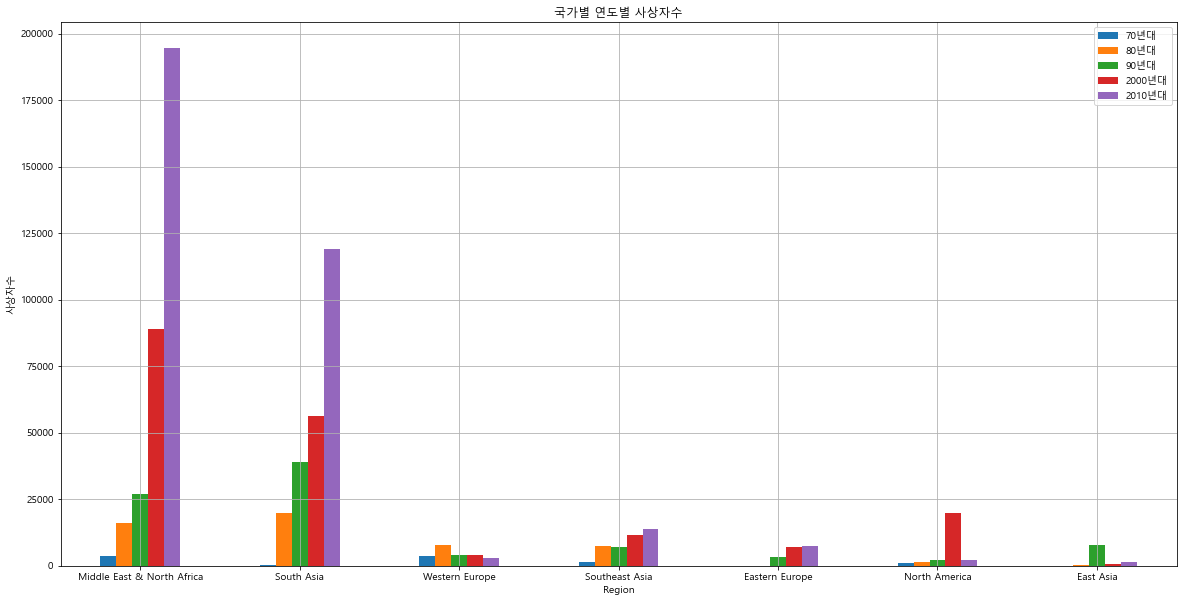

In [409]:
period_raw_new.plot(x="Region", y=["70년대", "80년대", "90년대", "2000년대", "2010년대"], kind="bar", figsize=(20,10))
plt.title('국가별 연도별 사상자수')
plt.grid(True)
plt.xticks(rotation=360)
plt.ylabel("사상자수")
plt.show()

- 위 그래프를 보면 일단 사상자 수는 확실히 중동 & 북아프리카, 남아시아가 높은것으로 보여진다. 특히 눈에 띄는점은 두지역은 연도별로 남동아시아, 동유럽 지역과 더불어 꾸준히 증가하는 추세에 있다는 점이 눈에 띈다.
- 위 세 지역과 별개로 북미의 경우는 2000년대까지 증가추세에 있다가 2010년대 들어서 사상자수가 많이 줄어든점이 눈에 띈다.
- 나머지 서유럽과 동아시아 지역은 사상자도 다른 지역에 비해 눈에 띄게 적고 늘어나지 않고 있는것 처럼 보인다.

---

# 문제 7

- 우리나라의 테러를 집계해서 시각화 하고 분석해보기

In [378]:
# 한국 데이터 집계되고 있는것 확인
raw_data[raw_data["Country"] == "South Korea"].head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,casualities
2514,1974,8,15,South Korea,East Asia,Seoul,37.566535,126.977969,Assassination,1.0,0.0,"wife, Pres. Chung Hu Park",NaN,Korean Youth League,Government (General),Firearms,NaN,1.0
15734,1982,3,18,South Korea,East Asia,Busan,35.179554,129.075642,Facility/Infrastructure Attack,1.0,3.0,US Government Information Office,NaN,Unknown,Government (Diplomatic),Incendiary,NaN,4.0
19820,1983,9,22,South Korea,East Asia,Daegu,35.871435,128.601445,Bombing/Explosion,1.0,4.0,US Cultural Center (housed in a 5 story building),NaN,Unknown,Government (Diplomatic),Explosives,NaN,5.0
29151,1986,9,14,South Korea,East Asia,Gimpo International Airport,37.558947,126.798341,Bombing/Explosion,5.0,19.0,Kimpo International Airport,NaN,Unknown,Airports & Aircraft,Explosives,NaN,24.0
29696,1986,12,15,South Korea,East Asia,Busan,35.179554,129.075642,Armed Assault,0.0,11.0,US Information Svce Bldg,NaN,Student Radicals,Government (General),Melee,NaN,11.0


## 연도별 사상자수 분석

In [379]:
korea_year_raw = raw_data[raw_data["Country"] == "South Korea"]

In [381]:
korea_pivot_1 = korea_year_raw.pivot_table(index=["Region", "Year"], values=["Killed", "Wounded", "casualities"],aggfunc='sum')
korea_pivot_1.head()

Killed  Wounded  casualities
Region    Year                              
East Asia 1974     1.0      0.0          1.0
          1982     1.0      3.0          4.0
          1983     1.0      4.0          5.0
          1986     5.0     30.0         35.0
          1988     0.0      0.0          0.0

In [383]:
.reset_index(level=1, inplace=True)
korea_pivot_1.head()

,Year,Killed,Wounded,casualities
Region,,,,
East Asia,1974,1.0,0.0,1.0
East Asia,1982,1.0,3.0,4.0
East Asia,1983,1.0,4.0,5.0
East Asia,1986,5.0,30.0,35.0
East Asia,1988,0.0,0.0,0.0


In [385]:
# 사상자 연도별 정리
casualities1 = []
casualities2 = []
casualities3 = []
casualities4 = []
casualities5 = []

date1 = list(range(1970,1980))
date2 = list(range(1980,1990))
date3 = list(range(1990,2000))
date4 = list(range(2000,2010))
date5 = list(range(2010,2018))

tmp = korea_pivot_1.copy()
tmp = tmp.set_index("Year")
    # 1970
sum1 = 0
for year in date1:
    try:
        data = tmp.loc[year, "casualities"]
        if data != np.nan:
            sum1 += data
    except:
        sum1 += 0
casualities1.append(sum1)
# 1980
sum2 = 0
for year in date2:
    try:
        data = tmp.loc[year, "casualities"]
        if data != np.nan:
            sum2 += data
    except:
        sum2 += 0
casualities2.append(sum2)
# 1990
sum3 = 0
for year in date3:
    try:
        data = tmp.loc[year, "casualities"]
        if data != np.nan:
            sum3 += data
    except:
        sum3 += 0
casualities3.append(sum3)
# 2000
sum4 = 0
for year in date4:
    try:
        data = tmp.loc[year, "casualities"]
        if data != np.nan:
            sum4 += data
    except:
        sum4 += 0
casualities4.append(sum4)

#2010
sum5 = 0
for year in date5:
    try:
        data = tmp.loc[year, "casualities"]
        if data != np.nan:
            sum5 += data
    except:
        sum5 += 0
casualities5.append(sum5)


In [387]:
korea_period_new = korea_year_raw.pivot_table(index="Region", values=["Killed", "Wounded", "casualities"],aggfunc='sum')
korea_period_new

,Killed,Wounded,casualities
Region,,,
East Asia,10.0,134.0,144.0


In [388]:
korea_period_new.reset_index(inplace=True)
korea_period_new

,Region,Killed,Wounded,casualities
0,East Asia,10.0,134.0,144.0


In [389]:
korea_period_new.rename(columns={"Region": "Country"}, inplace=True)

In [390]:
korea_period_new

,Country,Killed,Wounded,casualities
0,East Asia,10.0,134.0,144.0


In [391]:
korea_period_new["Country"] = "Korea"
korea_period_new

,Country,Killed,Wounded,casualities
0,Korea,10.0,134.0,144.0


In [392]:
korea_period_new["70년대"] = casualities1
korea_period_new["80년대"] = casualities2
korea_period_new["90년대"] = casualities3
korea_period_new["2000년대"] = casualities4
korea_period_new["2010년대"] = casualities5

In [393]:
korea_period_new

,Country,Killed,Wounded,casualities,70년대,80년대,90년대,2000년대,2010년대
0,Korea,10.0,134.0,144.0,1.0,44.0,35.0,63.0,1.0


- 한국도 전반적으로 보면 2000년대 까지 증가하다 2010년대 사상자수가 많이 줄어든것으로 보인다.

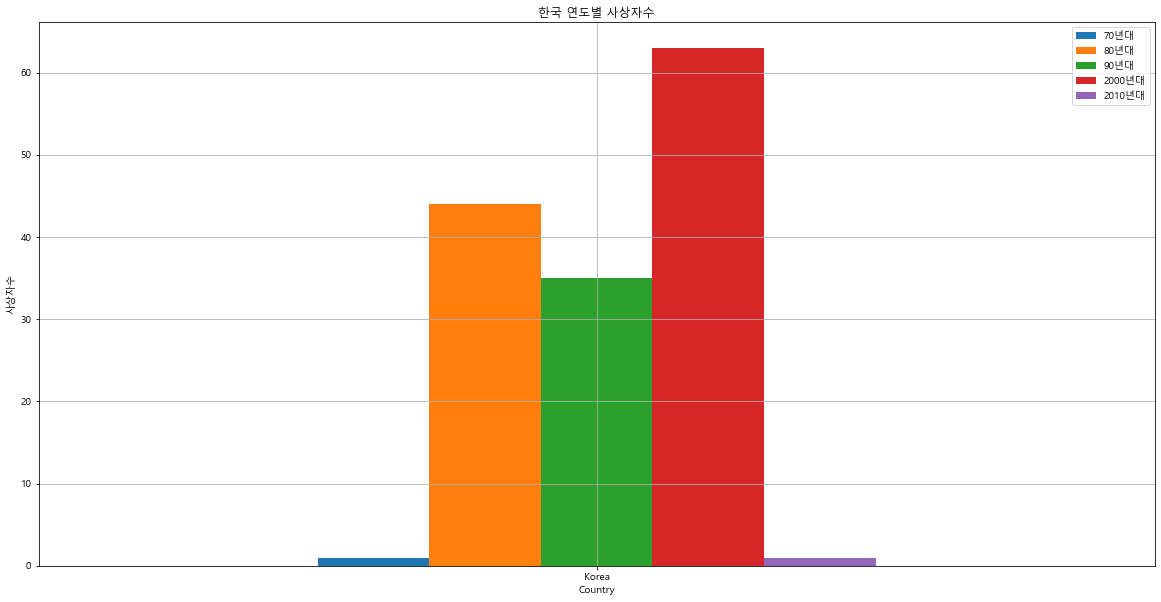

In [408]:
korea_period_new.plot(x="Country", y=["70년대", "80년대", "90년대", "2000년대", "2010년대"], kind="bar", figsize=(20,10))
plt.title('한국 연도별 사상자수')
plt.grid(True)
plt.xticks(rotation=360)
plt.ylabel("사상자수")
plt.show()

- 한국의 경우를 보면 70~80년대 사이 사상자수가 급등했다 2000년대 최고치를 찍고 2010년도의 경우 거의 발생하지 않는것으로 보인다.
- 위에서 살펴봣듯이 상위 10개 국가에서 사상자수가 거의 20만명이 나온것에 비하면 상당히 적은 수치라고 할수 있을것 같다.

## 공격방법별 분석

In [397]:
korea_year_raw.head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,casualities
2514,1974,8,15,South Korea,East Asia,Seoul,37.566535,126.977969,Assassination,1.0,0.0,"wife, Pres. Chung Hu Park",NaN,Korean Youth League,Government (General),Firearms,NaN,1.0
15734,1982,3,18,South Korea,East Asia,Busan,35.179554,129.075642,Facility/Infrastructure Attack,1.0,3.0,US Government Information Office,NaN,Unknown,Government (Diplomatic),Incendiary,NaN,4.0
19820,1983,9,22,South Korea,East Asia,Daegu,35.871435,128.601445,Bombing/Explosion,1.0,4.0,US Cultural Center (housed in a 5 story building),NaN,Unknown,Government (Diplomatic),Explosives,NaN,5.0
29151,1986,9,14,South Korea,East Asia,Gimpo International Airport,37.558947,126.798341,Bombing/Explosion,5.0,19.0,Kimpo International Airport,NaN,Unknown,Airports & Aircraft,Explosives,NaN,24.0
29696,1986,12,15,South Korea,East Asia,Busan,35.179554,129.075642,Armed Assault,0.0,11.0,US Information Svce Bldg,NaN,Student Radicals,Government (General),Melee,NaN,11.0


In [398]:
korea_at_type = korea_year_raw.pivot_table(index="AttackType", values=["Killed", "Wounded", "casualities"],aggfunc='sum')
korea_at_type

,Killed,Wounded,casualities
AttackType,,,
Armed Assault,0.0,72.0,72.0
Assassination,2.0,1.0,3.0
Bombing/Explosion,6.0,25.0,31.0
Facility/Infrastructure Attack,1.0,4.0,5.0
Hostage Taking (Kidnapping),0.0,0.0,0.0
Unarmed Assault,1.0,30.0,31.0
Unknown,0.0,2.0,2.0


- 한국의 경우는 무장폭행이 가장 많은점이 눈에 띈다. 상위 10개 국가에서는 폭팔물 테러가 거의 대부분이었는데 한국은 무장폭행 > 폭팔물 테러 > 비무장 폭행 순으로 관찰 되고 있다.

In [399]:
# 시각화
korea_at_type.reset_index(inplace=True)
korea_at_type

,AttackType,Killed,Wounded,casualities
0,Armed Assault,0.0,72.0,72.0
1,Assassination,2.0,1.0,3.0
2,Bombing/Explosion,6.0,25.0,31.0
3,Facility/Infrastructure Attack,1.0,4.0,5.0
4,Hostage Taking (Kidnapping),0.0,0.0,0.0
5,Unarmed Assault,1.0,30.0,31.0
6,Unknown,0.0,2.0,2.0


In [403]:
korea_at_type = korea_at_type.sort_values(by="casualities", ascending=False)

No handles with labels found to put in legend.


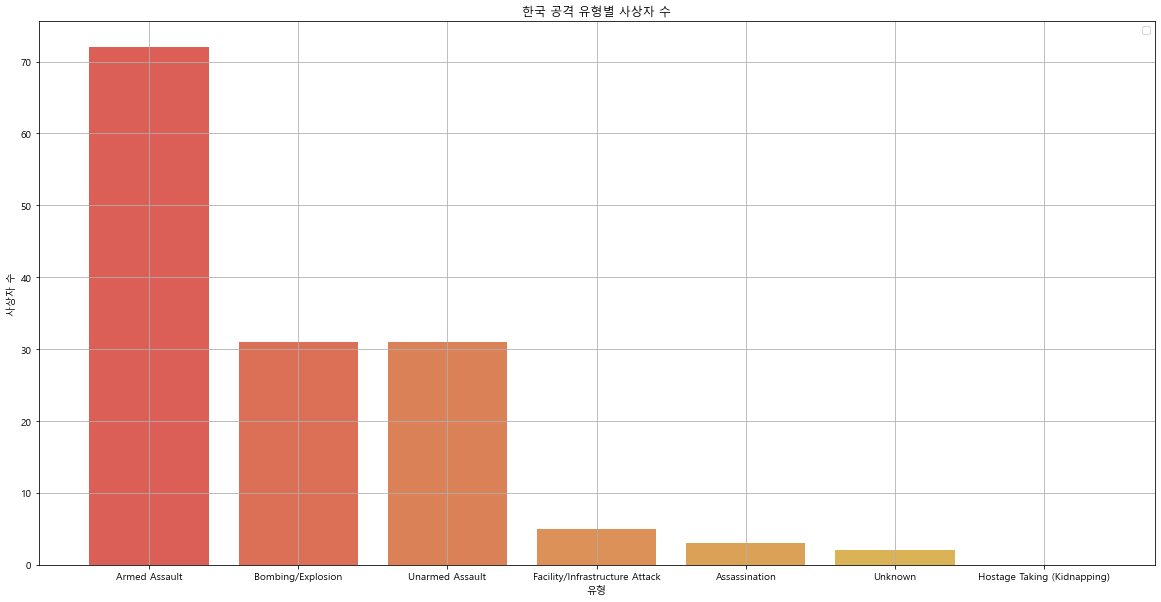

In [404]:
plt.figure(figsize=(20, 10))
colors = sns.color_palette('hls', len(yearly_data))
plt.bar(korea_at_type["AttackType"], korea_at_type["casualities"], color=colors)
plt.legend()
plt.grid(True)
plt.title('한국 공격 유형별 사상자 수')
plt.xlabel("유형")
plt.ylabel("사상자 수")
plt.show()

- 위 차트를 보면 알수 있듯이 무장폭행으로 인한 사상자수가 압도적으로 많고 그 다음 폭팔물, 비무장폭행으로 인한 사상자 수가 대부분을 차지하고 있다.

---

# 문제8

- 테러의 어둡고 무서운 면을 강조할 수 있는 방법을고민해 데이터를 분석하고 시각화 해보기

In [405]:
raw_data.head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,casualities
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,Julio Guzman,NaN,MANO-D,Private Citizens & Property,Unknown,NaN,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,Hostage Taking (Kidnapping),0.0,0.0,"Nadine Chaval, daughter",NaN,23rd of September Communist League,Government (Diplomatic),Unknown,NaN,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Employee,NaN,Unknown,Journalists & Media,Unknown,NaN,1.0
3,1970,1,0,Greece,Western Europe,Athens,37.997490,23.762728,Bombing/Explosion,NaN,NaN,U.S. Embassy,NaN,Unknown,Government (Diplomatic),Explosives,NaN,NaN
4,1970,1,0,Japan,East Asia,Fukouka,33.580412,130.396361,Facility/Infrastructure Attack,NaN,NaN,U.S. Consulate,NaN,Unknown,Government (Diplomatic),Incendiary,NaN,NaN


- 문제의 자료에서 테러와 상관없는 민간인이 피해입는 자료를 예시로 받았다. 지금까지 문제에서 살펴봣듯이 보통 테러는 여러가지 이유로 일어났다. 정치적인 이유, 종교적인 이유, 원인불명의 이유등등 기타 이유들이 많았다.
공격 방식 역시 여러가지가 있었다. 폭팔물, 폭행, 납치 등등 여러가지 유형이 있었다. 그 중 폭팔물로 인한 시도가 가장 많았던 것을 확인할 수 있었고 아마도 폭팔물로 인한 사상자 또한 가장 많을 것이다라고 예측할 수 있을것이다.
그러면 우리가 조사한 raw_data에서 타겟 유형별 사상자 수는 어떻게 되는 것일까

In [410]:
dark_side = raw_data.pivot_table(index="Target_type", values="casualities", aggfunc="sum")
dark_side.head()

,casualities
Target_type,
Abortion Related,55.0
Airports & Aircraft,6795.0
Business,75477.0
Educational Institution,13574.0
Food or Water Supply,501.0


In [411]:
dark_side.reset_index(inplace=True)
dark_side

,Target_type,casualities
0,Abortion Related,55.0
1,Airports & Aircraft,6795.0
2,Business,75477.0
3,Educational Institution,13574.0
4,Food or Water Supply,501.0
5,Government (Diplomatic),13121.0
6,Government (General),64957.0
7,Journalists & Media,3093.0
8,Maritime,1965.0
9,Military,155194.0


In [413]:
dark_side = dark_side.sort_values(by="casualities", ascending=False)

In [415]:
dark_side

,Target_type,casualities
13,Private Citizens & Property,295314.0
9,Military,155194.0
12,Police,113272.0
2,Business,75477.0
6,Government (General),64957.0
18,Transportation,53791.0
14,Religious Figures/Institutions,36031.0
16,Terrorists/Non-State Militia,15617.0
3,Educational Institution,13574.0
5,Government (Diplomatic),13121.0


- 실제로 피해자 유형별 사상자수를 보니 예상했던 결과와 좀 다르게 나왔다. 실제로 사상자 유형은 private Citizen & property 가 가장 높게 나왔다. 그 다음 실제 테러에 맞서싸워 대항하고 있는 군인, 경찰들이 많이 잡혔고
어떤 사업체, 정부, 교통, 종교 단체등이 나왔지만 민간인에서 가장 높은 사상률이 나오는건 좋지 못한 결과인것 같다.

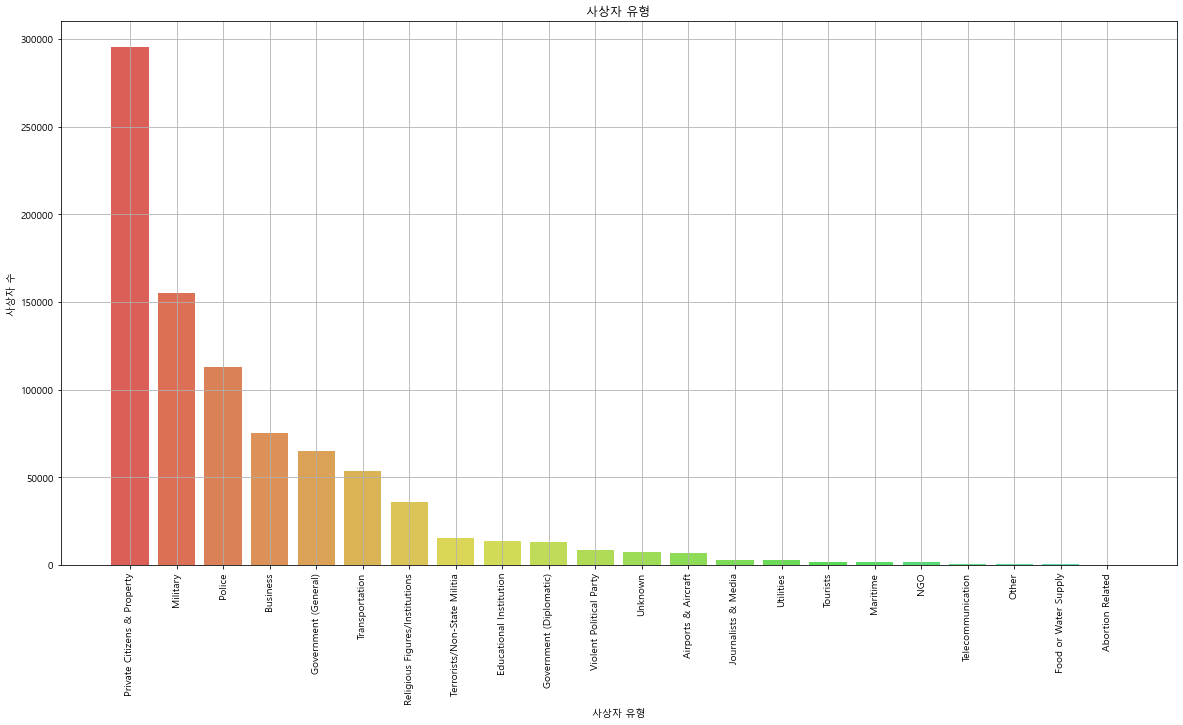

In [428]:
# 시각화 1
plt.figure(figsize=(20, 10))
colors = sns.color_palette('hls', len(yearly_data))
plt.bar(dark_side["Target_type"], dark_side["casualities"], color=colors)
plt.grid(True)
plt.title('사상자 유형')
plt.xlabel("사상자 유형")
plt.xticks(rotation=90)
plt.ylabel("사상자 수")
plt.show()

In [419]:
# 시각화 2
total = dark_side["casualities"].sum()

dark_side["ratio"] = dark_side["casualities"] / total

In [420]:
dark_side

,Target_type,casualities,ratio
13,Private Citizens & Property,295314.0,0.338317
9,Military,155194.0,0.177793
12,Police,113272.0,0.129766
2,Business,75477.0,0.086468
6,Government (General),64957.0,0.074416
18,Transportation,53791.0,0.061624
14,Religious Figures/Institutions,36031.0,0.041278
16,Terrorists/Non-State Militia,15617.0,0.017891
3,Educational Institution,13574.0,0.015551
5,Government (Diplomatic),13121.0,0.015032


In [426]:
tmp = dark_side[:10]
tmp

,Target_type,casualities,ratio
13,Private Citizens & Property,295314.0,0.338317
9,Military,155194.0,0.177793
12,Police,113272.0,0.129766
2,Business,75477.0,0.086468
6,Government (General),64957.0,0.074416
18,Transportation,53791.0,0.061624
14,Religious Figures/Institutions,36031.0,0.041278
16,Terrorists/Non-State Militia,15617.0,0.017891
3,Educational Institution,13574.0,0.015551
5,Government (Diplomatic),13121.0,0.015032


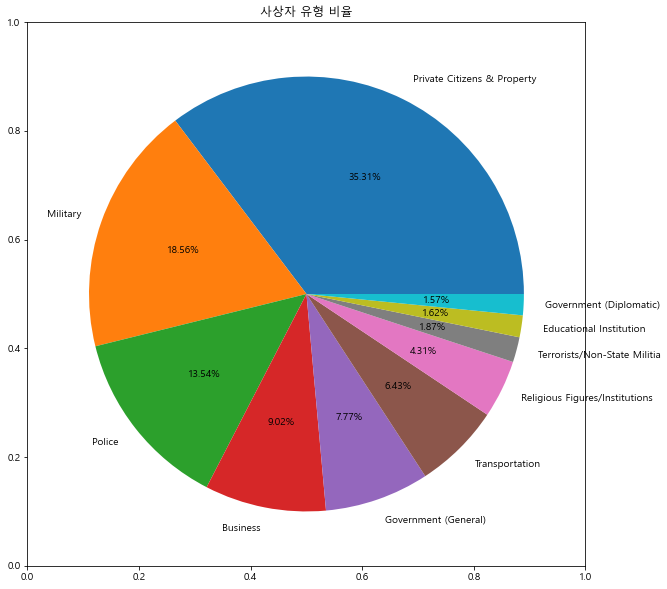

In [427]:
plt.figure(figsize=(10, 10))
plt.title('사상자 유형 비율')
ax = plt.axes()
ax.set_facecolor('white')
plt.pie(tmp["ratio"] * 100, labels=tmp["Target_type"], autopct='%.2f%%')

plt.show()

- 위의 파이차트를 보게 되면 1/3의 넘는 비율을 민간시민이 차지하고 있음을 알 수 있다.
위 데이터 결과로부터 알수 있듯이 테러의 동기가 어떻게 됫건 민간인들이 가장 많은 피해를 받고 있음을 알고 있다.
또한 테러를 진압하기 위해 노력하는 군인들과 경찰들의 퍼센트 까지 합치면 거의 70%에 육박하는 수치가 나오고 있다.
다른 유형들도물론 심각한 문제를 야기시키긴 하지만 특정 목표를 이루기위해 벌이는 일들이 그 일과 무관한 사람들을 다치게 하고 있다.
이런점으로 보아 테러는 무관한 사람들을 다치고 상처입게 하는 사회악 이라고 할 수 있을것 같다.


## 한상희, 본인은 이번 문제와 문제의 답을 외부로 유출하지 않겠습니다.